In [1]:
import os
from os import listdir
from os.path import isfile, join, splitext
import sys
import csv
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# list shp files recursively
os.chdir('..')
abs_path = os.getcwd()

HIFLD_path = os.path.join(abs_path, 'output/HIFLD/centroids')
#csv_files = [os.path.join(root, name) \
#             for root, dirs, files in os.walk(HIFLD_path) \
#             for name in files \
#             if name.endswith(('.csv'))]
csv_files = [f for f in listdir(HIFLD_path) if isfile(join(HIFLD_path, f)) and f.endswith(".csv")]
csv_paths = [join(HIFLD_path, a) for a in csv_files]

In [3]:
# number of observations per geoshape file 
for file in csv_paths:
    with open(file, 'rb') as f:
        row_count = len(f.readlines()) - 1
        
        basename = os.path.basename(file).split('/')[0]
        fname = os.path.basename(basename).split('.')[0]
        
        print('There are {} observations in {}.'.format(row_count, fname))

There are 39810 observations in centroids_40k.


# Parse Full Address
* Parse full address string to OMOP components
  * address_1
  * address_2
  * city
  * state
  * zip
  * county
  * location_source_value
  * latitude
  * longitude

In [4]:
# read all csv paths
test_list = []
for path in csv_paths:
    df = pd.read_csv(path)
    test_list.append(df)

test_addresses = pd.concat(test_list)

In [6]:
test_addresses['Full_Address'] = test_addresses.Full_Address

In [5]:
def parse_address(df, 
                  state_full_pattern,
                  state_abbr_pattern,
                  zip_code_pattern=r"[0-9]{5}(?:-[0-9]{4})?"
                  # state_code_pattern=r"[A-Z][a-z]+(?: +[A-Z][a-z]+)*)"
                 ):
    """
    Parse full address string to OMOP components by Regex search

    Parameters
    ----------
    df (DataFrame): Pandas DataFrame of source centroids with dates and user IDs

    Returns
    -------
    parse_df (DataFrame): DataFrame with parsed OMOP address components
    """
    tmp = []
    for i,row in df.iterrows():
        addr_components = row.Full_Address.split(',')

        # parse address if no RegEx match for 'APT'
        if len(re.findall(r'APT', row.Full_Address, flags=re.IGNORECASE)) == 0:
            state_zip = addr_components[2].split(' ')
            if len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)   
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = np.NaN
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0 and len(re.findall(state_full_pattern, addr_components[-1].title())) > 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())
                row['zip'] = np.NaN
    
                tmp.append(row)
                
        # # parse address if RegEx match for 'APT' to address_1 & address_2
        elif len(re.findall(r'APT', row.Full_Address, flags=re.IGNORECASE)) > 0:
            if len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', row.Full_Address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = np.NaN
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0 and len(re.findall(state_full_pattern, addr_components[-1].title())) > 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())
                row['zip'] = np.NaN
    
                tmp.append(row)
                    
        # # parse address if RegEx match for 'Suite' to to address_1 & address_2
        elif len(re.findall(r'SUITE', row.Full_Address, flags=re.IGNORECASE)) > 0:
            if len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]

                tmp.append(row)

            elif len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = np.NaN
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0 and len(re.findall(state_full_pattern, addr_components[-1].title())) > 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())
                row['zip'] = np.NaN
    
                tmp.append(row)        
        
    return pd.DataFrame(tmp)

In [8]:
%%time
#states = ['IA', 'KS', 'UT', 'VA', 'NC', 'NE', 'SD', 'AL', 'ID', 'FM', 'DE', 'AK', 'CT', 'PR', 'NM', 'MS', 'PW', 'CO', 'NJ', 'FL', 'MN', 'VI', 'NV', 'AZ', 'WI', 'ND', 'PA', 'OK', 'KY', 'RI', 'NH', 'MO', 'ME', 'VT', 'GA', 'GU', 'AS', 'NY', 'CA', 'HI', 'IL', 'TN', 'MA', 'OH', 'MD', 'MI', 'WY', 'WA', 'OR', 'MH', 'SC', 'IN', 'LA', 'MP', 'DC', 'MT', 'AR', 'WV', 'TX']
#regex = re.compile(r'\b(' + '|'.join(states) + r')\b', re.IGNORECASE)
state_full_pattern = r"/AL|Alabama|AK|Alaska|AZ|Arizona|AR|Arkansas|CA|California|CO|Colorado|CT|Connecticut|DE|Delaware|FL|Florida|GA|Georgia|HI|Hawaii|ID|Idaho|IL|Illinois|IN|Indiana|IA|Iowa|KS|Kansas|KY|Kentucky|LA|Louisiana|ME|Maine|MD|Maryland|MA|Massachusetts|MI|Michigan|MN|Minnesota|MS|Mississippi|MO|Missouri|MT|Montana|NE|Nebraska|NV|Nevada|NH|New Hampshire|NJ|New Jersey|NM|New Mexico|NY|New York|NC|North Carolina|ND|North Dakota|OH|Ohio|OK|Oklahoma|OR|Oregon|PA|Pennsylvania|RI|Rhode Island|SC|South Carolina|SD|South Dakota|TN|Tennessee|TX|Texas|UT|Utah|VT|Vermont|VA|Virginia|WA|Washington|WV|West Virginia|WI|Wisconsin|WY|Wyoming/"
state_abbr_pattern = re.compile(r'\b(AZ|CA|...|NJ|N\.J\.|NM|N\.M\.|...)\b')
state_abbr_case = r"^([Aa][LKSZRAEPlkszraep]|[Cc][AOTaot]|[Dd][ECec]|[Ff][LMlm]|[Gg][AUau]|[Hh][Ii]|[Ii][ADLNadln]|[Kk][SYsy]|[Ll][Aa]|[Mm][ADEHINOPSTadehinopst]|[Nn][CDEHJMVYcdehjmvy]|[Oo][HKRhkr]|[Pp][ARWarw]|[Rr][Ii]|[Ss][CDcd]|[Tt][NXnx]|[Uu][Tt]|[Vv][AITait]|[Ww][AIVYaivy])$"
zip_code_pattern=r"[0-9]{5}(?:-[0-9]{4})?"

new_df = parse_address(test_addresses, state_full_pattern, state_abbr_pattern)

CPU times: total: 43.3 s
Wall time: 1min 9s


In [9]:
new_df.isna().sum()

Full_Address           0
Place_type             0
source_centroid        0
source_lon             0
source_lat             0
address_1              0
address_2          39697
city                   0
state                  0
zip                   14
dtype: int64

In [10]:
new_df.loc[new_df.zip.isna()]

,Full_Address,Place_type,source_centroid,source_lon,source_lat,address_1,address_2,city,state,zip
15007,"None, None, NC 0None",Fire_Stations,POINT (-80.7334000115912 35.284413798121),-80.733400,35.284414,None,NaN,None,NC,NaN
15012,"None, None, NC 0None",Fire_Stations,POINT (-78.74809211424899 35.25522516235057),-78.748092,35.255225,None,NaN,None,NC,NaN
15029,"None, Silverstreet, SC 0None",Fire_Stations,POINT (-81.71611774790527 34.21869683310717),-81.716118,34.218697,None,NaN,Silverstreet,SC,NaN
15037,"None, None, NC 0None",Fire_Stations,POINT (-81.56439240062205 35.99897771778704),-81.564392,35.998978,None,NaN,None,NC,NaN
15038,"None, None, FL 0None",Fire_Stations,POINT (-82.01046527381023 27.9959887951315),-82.010465,27.995989,None,NaN,None,FL,NaN
15043,"None, None, MN 0None",Fire_Stations,POINT (-91.82644547020929 47.91360060801615),-91.826445,47.913601,None,NaN,None,MN,NaN
15047,"None, None, AR 0None",Fire_Stations,POINT (-92.93847405314527 36.26835177008476),-92.938474,36.268352,None,NaN,None,AR,NaN
15057,"None, None, NC 0None",Fire_Stations,POINT (-78.73948752494326 35.51181401754774),-78.739488,35.511814,None,NaN,None,NC,NaN
15059,"None, None, IL 0None",Fire_Stations,POINT (-90.35161688062396 39.18930663393451),-90.351617,39.189307,None,NaN,None,IL,NaN
15063,"None, None, NC 0None",Fire_Stations,POINT (-78.60828457480469 35.30937667899446),-78.608285,35.309377,None,NaN,None,NC,NaN


In [11]:
def clean_address(df):
    """
    Removes 'address_2' value if not exact match for 'APT' on RegEx match

    Parameters
    ----------
    df (DataFrame): Pandas DataFrame of parsed addresses from parse_address()

    Returns
    -------
    df (DataFrame): with cleaned 'address_2' field
    """
    df['address_2'] = np.where(df.address_2.str.match('^APT ', flags=re.IGNORECASE), df.address_2, np.NaN)

    return df

In [12]:
new_df = clean_address(new_df)
new_df.loc[new_df.address_2.notna()]

,Full_Address,Place_type,source_centroid,source_lon,source_lat,address_1,address_2,city,state,zip
79,"75 MORTON VILLAGE DR APT 408, MATTAPAN, MA 02126",AllPlacesOfWorship,POINT (-71.08514899960493 42.28039500021873),-71.085149,42.280395,75 MORTON VILLAGE DR,APT 408,MATTAPAN,MA,02126
81,"200 HANCOCK ST APT 904, BANGOR, ME 04401",AllPlacesOfWorship,POINT (-68.76204999998546 44.80240600016944),-68.762050,44.802406,200 HANCOCK ST,APT 904,BANGOR,ME,04401
130,"430 GRANDVIEW AVE APT 17, BANGOR, ME 04401",AllPlacesOfWorship,POINT (-68.78194100006301 44.82778499975468),-68.781941,44.827785,430 GRANDVIEW AVE,APT 17,BANGOR,ME,04401
187,"33 GLENWOOD DR APT 2, BANGOR, ME 04401",AllPlacesOfWorship,POINT (-68.79561099971137 44.82339399971704),-68.795611,44.823394,33 GLENWOOD DR,APT 2,BANGOR,ME,04401
349,"8929 163RD ST APT 6J, JAMAICA, NY 11432",AllPlacesOfWorship,POINT (-73.79775400029403 40.70627900022771),-73.797754,40.706279,8929 163RD ST,APT 6J,JAMAICA,NY,11432
...,...,...,...,...,...,...,...,...,...,...
4733,"1605 METROPOLITAN AVE APT 4F, BRONX, NY 10462",AllPlacesOfWorship,POINT (-73.85637899986503 40.84040699999114),-73.856379,40.840407,1605 METROPOLITAN AVE,APT 4F,BRONX,NY,10462
4753,"84 TAYLOR AVE APT 1, NORWALK, CT 06854",AllPlacesOfWorship,POINT (-73.42949499993506 41.10205900028152),-73.429495,41.102059,84 TAYLOR AVE,APT 1,NORWALK,CT,06854
4820,"1 HOPKINS RD APT 3, LIVERPOOL, NY 13088",AllPlacesOfWorship,POINT (-76.18359599981609 43.10864899985945),-76.183596,43.108649,1 HOPKINS RD,APT 3,LIVERPOOL,NY,13088
4959,"558 BEDFORD AVE APT 1B, BROOKLYN, NY 11211",AllPlacesOfWorship,POINT (-73.96174099996421 40.70466000022958),-73.961741,40.704660,558 BEDFORD AVE,APT 1B,BROOKLYN,NY,11211


In [13]:
new_df.to_csv(os.path.join(HIFLD_path, "centroids_40k_OMOP.csv"), index=False)

# Parse with Lambda
* IGNORE THIS SECTION

In [88]:
test_addresses['state'] = test_addresses.Full_Addre.apply(lambda x: re.findall(state_abbr_pattern, x))

In [89]:
test_addresses

,Full_Addre,source_lon,source_lat,geometry,user_id,start_date,end_duration,end_date,state
0,"2499 SOUTH WILMINGTON AVENUE, COMPTON, CA 90220",-118.236303,33.868428,POINT (-118.23630253521881 33.86842825057474),1,2004-12-09,847 days,2007-04-05,[CA]
1,"420 South Pierre Street, Pierre, South Dakota ...",-98.695554,43.254257,POINT (-98.6955539999999 43.2542570000001),1,2006-02-04,527 days,2007-07-16,[420]
2,"12150 30 MILE ROAD, WASHINGTON, MI 48095",-83.013787,42.771167,POINT (-83.01378666886954 42.77116730707756),1,2018-07-12,949 days,2021-02-15,"[ 30, MI ]"
3,"65 TIFTON ELDORADO RD, TIFTON, GA 31794",-83.496325,31.445218,POINT (-83.49632463429873 31.445218156335972),2,2001-05-11,824 days,2003-08-13,"[65 , RD, GA ]"
4,"12512 WALTERS RD, HOUSTON, TX 77014",-95.468105,29.973519,POINT (-95.46810520662352 29.973518593722815),2,2004-01-09,924 days,2006-07-21,"[ RD, TX ]"
...,...,...,...,...,...,...,...,...,...
19995,"730 Reems Creek Road, Weaverville, NC 28787",-82.509238,35.694465,POINT (-82.50923810689038 35.6944646159304),4999,2006-04-17,628 days,2008-01-05,"[730, NC ]"
19996,"5793 South 700 East, Whitestown, IN 46075",-86.335915,39.955682,POINT (-86.33591469213522 39.95568248243973),4999,2010-05-21,463 days,2011-08-27,"[700, IN ]"
19997,"7150 E ARCH RD, STOCKTON, CA 95205",-121.187052,37.902070,POINT (-121.1870524708539 37.90207040341747),4999,2012-09-17,930 days,2015-04-05,"[ E , RD, CA]"
19998,"1075 GARRISONVILLE ROAD, STAFFORD, VA 22556",-77.469689,38.474291,POINT (-77.46968895783967 38.474291425596675),4999,2016-07-19,727 days,2018-07-16,[VA ]


In [79]:
state_abbr_pattern = re.compile(r'\b(AZ|CA|...|NJ|N\.J\.|NM|N\.M\.|...)\b')

re.findall(state_abbr_pattern, '2499 SOUTH WILMINGTON AVENUE, COMPTON, CA 90220')

['CA']

In [84]:
re.findall(state_full_pattern, '420 South Pierre Street, Pierre, South Dakota'.title())

['South Dakota']

In [48]:
state_full_pattern = r"/AL|Alabama|AK|Alaska|AZ|Arizona|AR|Arkansas|CA|California|CO|Colorado|CT|Connecticut|DE|Delaware|FL|Florida|GA|Georgia|HI|Hawaii|ID|Idaho|IL|Illinois|IN|Indiana|IA|Iowa|KS|Kansas|KY|Kentucky|LA|Louisiana|ME|Maine|MD|Maryland|MA|Massachusetts|MI|Michigan|MN|Minnesota|MS|Mississippi|MO|Missouri|MT|Montana|NE|Nebraska|NV|Nevada|NH|New Hampshire|NJ|New Jersey|NM|New Mexico|NY|New York|NC|North Carolina|ND|North Dakota|OH|Ohio|OK|Oklahoma|OR|Oregon|PA|Pennsylvania|RI|Rhode Island|SC|South Carolina|SD|South Dakota|TN|Tennessee|TX|Texas|UT|Utah|VT|Vermont|VA|Virginia|WA|Washington|WV|West Virginia|WI|Wisconsin|WY|Wyoming/"
state_abbr_pattern = re.compile(r'\b(AZ|CA|...|NJ|N\.J\.|NM|N\.M\.|...)\b')
state_abbr_case = r"^([Aa][LKSZRAEPlkszraep]|[Cc][AOTaot]|[Dd][ECec]|[Ff][LMlm]|[Gg][AUau]|[Hh][Ii]|[Ii][ADLNadln]|[Kk][SYsy]|[Ll][Aa]|[Mm][ADEHINOPSTadehinopst]|[Nn][CDEHJMVYcdehjmvy]|[Oo][HKRhkr]|[Pp][ARWarw]|[Rr][Ii]|[Ss][CDcd]|[Tt][NXnx]|[Uu][Tt]|[Vv][AITait]|[Ww][AIVYaivy])$"
zip_code_pattern=r"[0-9]{5}(?:-[0-9]{4})?"

test_addresses['zip'] = test_addresses.Full_Addre.apply(lambda x: re.findall(zip_code_pattern, x)[0] if len(re.findall(zip_code_pattern, x))>0 else np.NaN)
test_addresses['state'] = test_addresses.Full_Addre.apply(lambda x: re.findall(state_abbr_case, x)[0] if len(re.findall(state_abbr_case, x))>0 else (re.findall(state_full_pattern, x.title())[0] if len(re.findall(state_full_pattern, x.title()))>0 else np.NaN))
# test_addresses['state'] = test_addresses.Full_Addre.apply(lambda x: re.findall(state_full_pattern, x.title())[0] if len(re.findall(state_full_pattern, x.title()))>0 else np.NaN)
# test_addresses['state'] = test_addresses.Full_Addre.apply(lambda x: re.findall(state_abbr_pattern, x[0] if (len(re.findall(state_abbr_pattern, x)>0) and (np.isnan(x)) else np.NaN)

SyntaxError: invalid syntax (2629627975.py, line 9)

In [46]:
test_addresses

,Full_Addre,source_lon,source_lat,geometry,user_id,start_date,end_duration,end_date,zip,state
0,"2499 SOUTH WILMINGTON AVENUE, COMPTON, CA 90220",-118.236303,33.868428,POINT (-118.23630253521881 33.86842825057474),1,2004-12-09,847 days,2007-04-05,90220,NaN
1,"420 South Pierre Street, Pierre, South Dakota ...",-98.695554,43.254257,POINT (-98.6955539999999 43.2542570000001),1,2006-02-04,527 days,2007-07-16,57501,South Dakota
2,"12150 30 MILE ROAD, WASHINGTON, MI 48095",-83.013787,42.771167,POINT (-83.01378666886954 42.77116730707756),1,2018-07-12,949 days,2021-02-15,12150,Washington
3,"65 TIFTON ELDORADO RD, TIFTON, GA 31794",-83.496325,31.445218,POINT (-83.49632463429873 31.445218156335972),2,2001-05-11,824 days,2003-08-13,31794,NaN
4,"12512 WALTERS RD, HOUSTON, TX 77014",-95.468105,29.973519,POINT (-95.46810520662352 29.973518593722815),2,2004-01-09,924 days,2006-07-21,12512,NaN
...,...,...,...,...,...,...,...,...,...,...
19995,"730 Reems Creek Road, Weaverville, NC 28787",-82.509238,35.694465,POINT (-82.50923810689038 35.6944646159304),4999,2006-04-17,628 days,2008-01-05,28787,NaN
19996,"5793 South 700 East, Whitestown, IN 46075",-86.335915,39.955682,POINT (-86.33591469213522 39.95568248243973),4999,2010-05-21,463 days,2011-08-27,46075,NaN
19997,"7150 E ARCH RD, STOCKTON, CA 95205",-121.187052,37.902070,POINT (-121.1870524708539 37.90207040341747),4999,2012-09-17,930 days,2015-04-05,95205,NaN
19998,"1075 GARRISONVILLE ROAD, STAFFORD, VA 22556",-77.469689,38.474291,POINT (-77.46968895783967 38.474291425596675),4999,2016-07-19,727 days,2018-07-16,22556,NaN


In [38]:
def parse_address(df, zip_code_pattern, state_abbr_pattern, state_full_pattern):
    df['zip'] = df.Full_Addre.apply(lambda x: re.findall(zip_code_pattern, x)[0] if len(re.findall(zip_code_pattern, x))>0 else np.NaN)

    addr_components = row.Full_Addre.split(',')

In [40]:
re.findall(state_abbr_case, test_addresses.Full_Addre[0])

[]

In [11]:
apt_string = re.findall(r'APT', 'APT 610B', flags=re.IGNORECASE)
print(apt_string)

['APT']


# Parse Centroids with Oversampling

In [7]:
def parse_address(df, 
                  state_full_pattern,
                  state_abbr_pattern,
                  zip_code_pattern=r"[0-9]{5}(?:-[0-9]{4})?"
                  # state_code_pattern=r"[A-Z][a-z]+(?: +[A-Z][a-z]+)*)"
                 ):
    """
    Parse full address string to OMOP components by Regex search

    Parameters
    ----------
    df (DataFrame): Pandas DataFrame of source centroids with dates and user IDs

    Returns
    -------
    parse_df (DataFrame): DataFrame with parsed OMOP address components
    """
    tmp = []
    for i,row in df.iterrows():
        addr_components = row.Full_Addre.split(',')

        # parse address if no RegEx match for 'APT'
        if len(re.findall(r'APT', row.Full_Addre, flags=re.IGNORECASE)) == 0:
            state_zip = addr_components[2].split(' ')
            if len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)   
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = np.NaN
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0 and len(re.findall(state_full_pattern, addr_components[-1].title())) > 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                row['address_1'] = addr_components[0]
                row['address_2'] = np.NaN
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())
                row['zip'] = np.NaN
    
                tmp.append(row)
                
        # # parse address if RegEx match for 'APT' to address_1 & address_2
        elif len(re.findall(r'APT', row.Full_Addre, flags=re.IGNORECASE)) > 0:
            if len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', row.Full_Addre, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = np.NaN
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0 and len(re.findall(state_full_pattern, addr_components[-1].title())) > 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                apt_string = re.findall(r'APT', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(apt_string)[0]
                row['address_2'] = base_address.partition(apt_string)[1] + base_address.partition(apt_string)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())
                row['zip'] = np.NaN
    
                tmp.append(row)
                    
        # # parse address if RegEx match for 'Suite' to to address_1 & address_2
        elif len(re.findall(r'SUITE', row.Full_Addre, flags=re.IGNORECASE)) > 0:
            if len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]

                tmp.append(row)

            elif len(re.findall(state_abbr_pattern, addr_components[-1])) > 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_abbr_pattern, addr_components[-1])[0]
                row['zip'] = np.NaN
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) > 0 and len(re.findall(state_full_pattern, addr_components[-1].title())) > 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())[0]
                row['zip'] = re.findall(zip_code_pattern, addr_components[-1])[0]
    
                tmp.append(row)
    
            elif len(re.findall(state_abbr_pattern, addr_components[-1])) == 0 and len(re.findall(zip_code_pattern, addr_components[-1])) == 0:
                base_address = addr_components[0]
                suite_str = re.findall(r'SUITE', base_address, flags=re.IGNORECASE)[0]
                row['address_1'] = base_address.partition(suite_str)[0]
                row['address_2'] = base_address.partition(suite_str)[1] + base_address.partition(suite_str)[2]
                row['city'] = addr_components[1]
                row['state'] = re.findall(state_full_pattern, addr_components[-1].title())
                row['zip'] = np.NaN
    
                tmp.append(row)        
        
    return pd.DataFrame(tmp)

In [2]:
os.chdir('..')
abs_path = os.getcwd()

sample_centroid_path = os.path.join(abs_path, 'output/sample_spatial_join.csv')

In [4]:
df = pd.read_csv(sample_centroid_path)
df

,Full_Addre,Place_type,source_lon,source_lat,geometry,index_right,OBJECTID,GEOID_1,NAME_1,NAMELSAD_1,Eligible_L,Shape_Leng,Shape_Le_1,Shape_Area,Tribal
0,"523 E BROADWAY, SOUTH BOSTON, MA 02127",AllPlacesOfWorship,-71.043522,42.335472,POINT (-71.04352199999346 42.33547200002667),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,"454 ESSEX ST, LAWRENCE, MA 01840",AllPlacesOfWorship,-71.164940,42.706213,POINT (-71.16493999969576 42.70621300000711),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,"569 BROADWAY, NEWARK, NJ 07104",AllPlacesOfWorship,-74.162821,40.769935,POINT (-74.16282099988595 40.76993499987205),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,"3210 SOUTHWESTERN BLVD, ORCHARD PARK, NY 14127",AllPlacesOfWorship,-78.747816,42.798535,POINT (-78.74781599997843 42.79853499984358),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,"431 CAMPGROUND RD, LIVERMORE FLS, ME 04254",AllPlacesOfWorship,-70.113777,44.428610,POINT (-70.11377699970232 44.42860999977688),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89211,"1300 PEACHTREE INDUSTRIAL BOULEVARD, SUWANEE, ...",UrgentCareFacs,-84.095174,34.041727,POINT (-84.09517421962246 34.04172694900986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
89212,"2660 SATELLITE BOULEVARD NORTHWEST, DULUTH, GA...",UrgentCareFacs,-84.101318,33.966797,POINT (-84.10131848955332 33.96679709299809),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
89213,"3685 BRASELTON HIGHWAY, DACULA, GA 30019",UrgentCareFacs,-83.902215,34.068832,POINT (-83.90221543184028 34.06883234729177),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
89214,"1055 DOVE RUN ROAD, LEXINGTON, KY 40502",UrgentCareFacs,-84.494106,37.996508,POINT (-84.49410603994914 37.99650802456039),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [8]:
%%time

state_full_pattern = r"/AL|Alabama|AK|Alaska|AZ|Arizona|AR|Arkansas|CA|California|CO|Colorado|CT|Connecticut|DE|Delaware|FL|Florida|GA|Georgia|HI|Hawaii|ID|Idaho|IL|Illinois|IN|Indiana|IA|Iowa|KS|Kansas|KY|Kentucky|LA|Louisiana|ME|Maine|MD|Maryland|MA|Massachusetts|MI|Michigan|MN|Minnesota|MS|Mississippi|MO|Missouri|MT|Montana|NE|Nebraska|NV|Nevada|NH|New Hampshire|NJ|New Jersey|NM|New Mexico|NY|New York|NC|North Carolina|ND|North Dakota|OH|Ohio|OK|Oklahoma|OR|Oregon|PA|Pennsylvania|RI|Rhode Island|SC|South Carolina|SD|South Dakota|TN|Tennessee|TX|Texas|UT|Utah|VT|Vermont|VA|Virginia|WA|Washington|WV|West Virginia|WI|Wisconsin|WY|Wyoming/"
state_abbr_pattern = re.compile(r'\b(AZ|CA|...|NJ|N\.J\.|NM|N\.M\.|...)\b')
state_abbr_case = r"^([Aa][LKSZRAEPlkszraep]|[Cc][AOTaot]|[Dd][ECec]|[Ff][LMlm]|[Gg][AUau]|[Hh][Ii]|[Ii][ADLNadln]|[Kk][SYsy]|[Ll][Aa]|[Mm][ADEHINOPSTadehinopst]|[Nn][CDEHJMVYcdehjmvy]|[Oo][HKRhkr]|[Pp][ARWarw]|[Rr][Ii]|[Ss][CDcd]|[Tt][NXnx]|[Uu][Tt]|[Vv][AITait]|[Ww][AIVYaivy])$"
zip_code_pattern=r"[0-9]{5}(?:-[0-9]{4})?"

parse_df = parse_address(df, state_full_pattern, state_abbr_pattern)
parse_df

CPU times: total: 1min 16s
Wall time: 2min 52s


,Full_Addre,Place_type,source_lon,source_lat,geometry,index_right,OBJECTID,GEOID_1,NAME_1,NAMELSAD_1,Eligible_L,Shape_Leng,Shape_Le_1,Shape_Area,Tribal,address_1,address_2,city,state,zip
0,"523 E BROADWAY, SOUTH BOSTON, MA 02127",AllPlacesOfWorship,-71.043522,42.335472,POINT (-71.04352199999346 42.33547200002667),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,523 E BROADWAY,NaN,SOUTH BOSTON,MA,02127
1,"454 ESSEX ST, LAWRENCE, MA 01840",AllPlacesOfWorship,-71.164940,42.706213,POINT (-71.16493999969576 42.70621300000711),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,454 ESSEX ST,NaN,LAWRENCE,MA,01840
2,"569 BROADWAY, NEWARK, NJ 07104",AllPlacesOfWorship,-74.162821,40.769935,POINT (-74.16282099988595 40.76993499987205),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,569 BROADWAY,NaN,NEWARK,NJ,07104
3,"3210 SOUTHWESTERN BLVD, ORCHARD PARK, NY 14127",AllPlacesOfWorship,-78.747816,42.798535,POINT (-78.74781599997843 42.79853499984358),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3210 SOUTHWESTERN BLVD,NaN,ORCHARD PARK,NY,14127
4,"431 CAMPGROUND RD, LIVERMORE FLS, ME 04254",AllPlacesOfWorship,-70.113777,44.428610,POINT (-70.11377699970232 44.42860999977688),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,431 CAMPGROUND RD,NaN,LIVERMORE FLS,ME,04254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89211,"1300 PEACHTREE INDUSTRIAL BOULEVARD, SUWANEE, ...",UrgentCareFacs,-84.095174,34.041727,POINT (-84.09517421962246 34.04172694900986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1300 PEACHTREE INDUSTRIAL BOULEVARD,NaN,SUWANEE,GA,30024
89212,"2660 SATELLITE BOULEVARD NORTHWEST, DULUTH, GA...",UrgentCareFacs,-84.101318,33.966797,POINT (-84.10131848955332 33.96679709299809),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2660 SATELLITE BOULEVARD NORTHWEST,NaN,DULUTH,GA,30096
89213,"3685 BRASELTON HIGHWAY, DACULA, GA 30019",UrgentCareFacs,-83.902215,34.068832,POINT (-83.90221543184028 34.06883234729177),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3685 BRASELTON HIGHWAY,NaN,DACULA,GA,30019
89214,"1055 DOVE RUN ROAD, LEXINGTON, KY 40502",UrgentCareFacs,-84.494106,37.996508,POINT (-84.49410603994914 37.99650802456039),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1055 DOVE RUN ROAD,NaN,LEXINGTON,KY,40502


In [10]:
parse_df.to_csv(os.path.join(abs_path, "output/sample_spatial_join_OMOP.csv"), index=False)

# Clean Parsed OMOP Columns

In [11]:
parse_df.columns

Index(['Full_Addre', 'Place_type', 'source_lon', 'source_lat', 'geometry',
       'index_right', 'OBJECTID', 'GEOID_1', 'NAME_1', 'NAMELSAD_1',
       'Eligible_L', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'Tribal',
       'address_1', 'address_2', 'city', 'state', 'zip'],
      dtype='object')

In [25]:
parse_df_clean = parse_df.loc[~parse_df.Full_Addre.str.contains('None')]
parse_df_clean

,Full_Addre,Place_type,source_lon,source_lat,geometry,index_right,OBJECTID,GEOID_1,NAME_1,NAMELSAD_1,Eligible_L,Shape_Leng,Shape_Le_1,Shape_Area,Tribal,address_1,address_2,city,state,zip
0,"523 E BROADWAY, SOUTH BOSTON, MA 02127",AllPlacesOfWorship,-71.043522,42.335472,POINT (-71.04352199999346 42.33547200002667),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,523 E BROADWAY,NaN,SOUTH BOSTON,MA,02127
1,"454 ESSEX ST, LAWRENCE, MA 01840",AllPlacesOfWorship,-71.164940,42.706213,POINT (-71.16493999969576 42.70621300000711),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,454 ESSEX ST,NaN,LAWRENCE,MA,01840
2,"569 BROADWAY, NEWARK, NJ 07104",AllPlacesOfWorship,-74.162821,40.769935,POINT (-74.16282099988595 40.76993499987205),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,569 BROADWAY,NaN,NEWARK,NJ,07104
3,"3210 SOUTHWESTERN BLVD, ORCHARD PARK, NY 14127",AllPlacesOfWorship,-78.747816,42.798535,POINT (-78.74781599997843 42.79853499984358),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3210 SOUTHWESTERN BLVD,NaN,ORCHARD PARK,NY,14127
4,"431 CAMPGROUND RD, LIVERMORE FLS, ME 04254",AllPlacesOfWorship,-70.113777,44.428610,POINT (-70.11377699970232 44.42860999977688),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,431 CAMPGROUND RD,NaN,LIVERMORE FLS,ME,04254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89211,"1300 PEACHTREE INDUSTRIAL BOULEVARD, SUWANEE, ...",UrgentCareFacs,-84.095174,34.041727,POINT (-84.09517421962246 34.04172694900986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1300 PEACHTREE INDUSTRIAL BOULEVARD,NaN,SUWANEE,GA,30024
89212,"2660 SATELLITE BOULEVARD NORTHWEST, DULUTH, GA...",UrgentCareFacs,-84.101318,33.966797,POINT (-84.10131848955332 33.96679709299809),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2660 SATELLITE BOULEVARD NORTHWEST,NaN,DULUTH,GA,30096
89213,"3685 BRASELTON HIGHWAY, DACULA, GA 30019",UrgentCareFacs,-83.902215,34.068832,POINT (-83.90221543184028 34.06883234729177),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3685 BRASELTON HIGHWAY,NaN,DACULA,GA,30019
89214,"1055 DOVE RUN ROAD, LEXINGTON, KY 40502",UrgentCareFacs,-84.494106,37.996508,POINT (-84.49410603994914 37.99650802456039),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1055 DOVE RUN ROAD,NaN,LEXINGTON,KY,40502


In [34]:
def multipleReplace(text, wordDict):
    for key in wordDict:
        text = text.replace(key, wordDict[key])
    return text

In [35]:
# replace state full name to abbreviation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [46]:
lst = []
for i,row in parse_df_clean.iterrows():
    if len(row.state) > 3:
        row['STATE'] = multipleReplace(row.state.strip(), us_state_to_abbrev)
        lst.append(row)
    else:
        row['STATE'] = row.state.strip()
        lst.append(row)

In [47]:
parse_df_clean = pd.concat(lst, axis=1).transpose()

In [49]:
parse_df_clean.to_csv(os.path.join(abs_path, "output/sample_spatial_join_OMOP_clean.csv"), index=False)

# Tribal Counts

In [54]:
tribal_counts = pd.DataFrame(parse_df_clean.groupby('STATE')['Tribal'].count())
tribal_counts

,Tribal
STATE,
AK,2155
AL,642
AR,424
AS,2
AZ,7417
...,...
VT,306
WA,487
WI,519


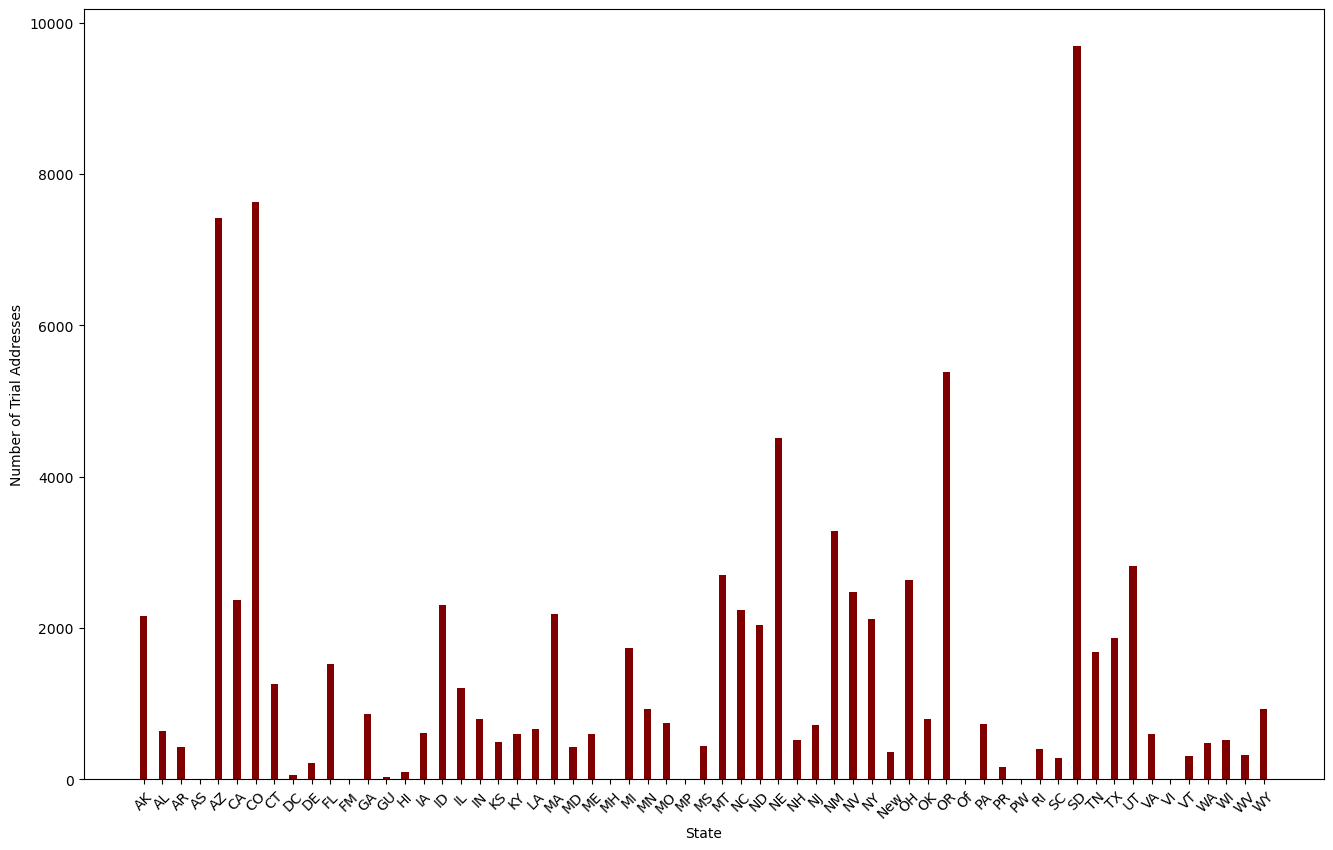

In [62]:
# barplot of distribution of tribal addresses by state or US territory
fig = plt.figure(figsize = (16, 10))

plt.bar(tribal_counts.index, tribal_counts['Tribal'], color ='maroon', width = 0.4)
plt.xlabel("State")
plt.ylabel("Number of Trial Addresses")
plt.xticks(rotation=45)
plt.show()